In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

In [22]:
def parse_data(file_path):
    count_header = 0
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    current_data = None
    section = None

    i = 0
    while i < len(lines):
        line = lines[i].strip()

        if line.startswith('header:') or line.endswith('header:') :
            count_header +=1
            if current_data is not None:
                # Save the previous data block if it exists
                data.append(current_data)
            
            # Initialize a new data block
            current_data = {
                'header': {},
                'robot_state': {},
                'current_errors': {},
                'last_motion_errors': {},
                'additional_info': {}
            }
            section = 'header'
        
        elif line.startswith('current_errors:'):
            section = 'current_errors'
        elif line.startswith('last_motion_errors:'):
            section = 'last_motion_errors'
        elif line.startswith('pose_desired:') or line.startswith('O_T_EE:') or line.startswith('O_T_EE_d:') or line.startswith('F_T_EE:') or line.startswith('EE_T_K:'):
            section = 'robot_state'
        elif line.startswith('control_command_success_rate:'):
            section = 'additional_info'

        # Process the current line based on the current section
        if current_data is not None:
            if section == 'header':
                if line.startswith('seq:'):
                    current_data['header']['seq'] = int(line.split(': ')[1])
                elif line.startswith('stamp:'):
                    i += 1
                    secs_line = lines[i].strip().split(': ')
                    current_data['header']['stamp'] = {'secs': int(secs_line[1])}
                    i += 1
                    nsecs_line = lines[i].strip().split(': ')
                    current_data['header']['stamp']['nsecs'] = int(nsecs_line[1])
                elif line.startswith('frame_id:'):
                    current_data['header']['frame_id'] = line.split(': ')[1].strip("'")
            
            elif section == 'current_errors' or section == 'last_motion_errors':
                key_value = line.split(': ')
                if len(key_value) == 2:
                    key = key_value[0].strip()
                    value = key_value[1].strip() == 'True'
                    if section == 'current_errors':
                        current_data['current_errors'][key] = value
                    elif section == 'last_motion_errors':
                        current_data['last_motion_errors'][key] = value
            
            elif section == 'robot_state':
                key_value = line.split(': ', 1)
                if len(key_value) == 2:
                    key = key_value[0].strip()
                    value = key_value[1].strip()
                    try:
                        parsed_value = json.loads(value)
                    except json.JSONDecodeError:
                        parsed_value = value
                    current_data['robot_state'][key] = parsed_value
            
            elif section == 'additional_info':
                key_value = line.split(': ')
                if len(key_value) == 2:
                    key = key_value[0]
                    value = key_value[1]
                    try:
                        value = float(value)
                        if value.is_integer():
                            value = int(value)
                    except ValueError:
                        if value == 'True':
                            value = True
                        elif value == 'False':
                            value = False
                    current_data['additional_info'][key] = value

        i += 1

    # Add the last data block if it exists
    if current_data is not None:
        data.append(current_data)
        
    print(f"there are {count_header} header")
    return data

# 将数据解析并保存为新的格式
file_path = '/Users/shangyu/Desktop/all_data.txt'
parsed_data = parse_data(file_path)

save_path = '/Users/shangyu/Desktop/all_data.json'
with open(save_path, 'w') as json_file:
    json.dump(parsed_data, json_file, indent=4)

save_path


there are 3625 header


'/Users/shangyu/Desktop/all_data.json'

In [ ]:
# 生成模拟的多时间点数据
def generate_sample_data(num_samples=10):
    data_list = []
    base_secs = 1698417764
    base_nsecs = 564254522
    for i in range(num_samples):
        data_point = {
            "header": {
                "seq": 530237 + i,
                "stamp": {
                    "secs": base_secs + i, 
                    "nsecs": base_nsecs + i * 1000
                },
                "frame_id": ""
            },
            "robot_state": {
                "q": np.random.rand(7).tolist(),
                "dq": np.random.rand(7).tolist(),
                "tau_J": np.random.rand(7).tolist()
            }
        }
        data_list.append(data_point)
    return data_list
# 生成 10 个时间点的数据
data_list = generate_sample_data(10)
data_list

In [23]:
json_file_path = '/Users/shangyu/Desktop/all_data.json'

with open(json_file_path,'r') as file:
    data_list = json.load(file)

In [24]:
# 提取时间戳并计算时间差
base_stamp = data_list[0]["header"]["stamp"]
time = []
for data in data_list:
    stamp = data["header"]["stamp"]
    delta_secs = stamp["secs"] - base_stamp["secs"]
    delta_nsecs = stamp["nsecs"] - base_stamp["nsecs"]
    time.append(delta_secs + delta_nsecs * 1e-9)
time = np.array(time)
time

array([0.00000000e+00, 4.72736300e-03, 9.72396700e-03, ...,
       1.81097369e+01, 1.81147231e+01, 1.81197267e+01])

In [25]:
# 提取每个时间点的数据
q_list = np.array([data["robot_state"]["q"] for data in data_list])

dq_list = np.array([data["robot_state"]["dq"] for data in data_list])

tau_J_list = np.array([data["robot_state"]["tau_J"] for data in data_list])

tau_ext_list = np.array([data["robot_state"]["tau_ext_hat_filtered"] for data in data_list]) 

In [26]:
# 平均每个关节的值
q_avg = q_list.mean(axis=1)
dq_avg = dq_list.mean(axis=1)
tau_J_avg = tau_J_list.mean(axis=1)
tau_ext_avg = tau_ext_list.mean(axis = 1)


In [27]:
# 定义 STFT 参数
fs = 1 / np.mean(np.diff(time))  # 采样频率
nperseg = len(time) // 2  # 每段的长度，调整为合适的值


In [28]:
# 计算 STFT
f_q, t_q, Zxx_q = stft(q_avg, fs=fs, nperseg=nperseg)
f_dq, t_dq, Zxx_dq = stft(dq_avg, fs=fs, nperseg=nperseg)
f_tau_J, t_tau_J, Zxx_tau_J = stft(tau_J_avg, fs=fs, nperseg=nperseg)
f_tau_ext, t_tau_ext, Zxx_tau_ext = stft(tau_ext_avg, fs=fs, nperseg=nperseg)

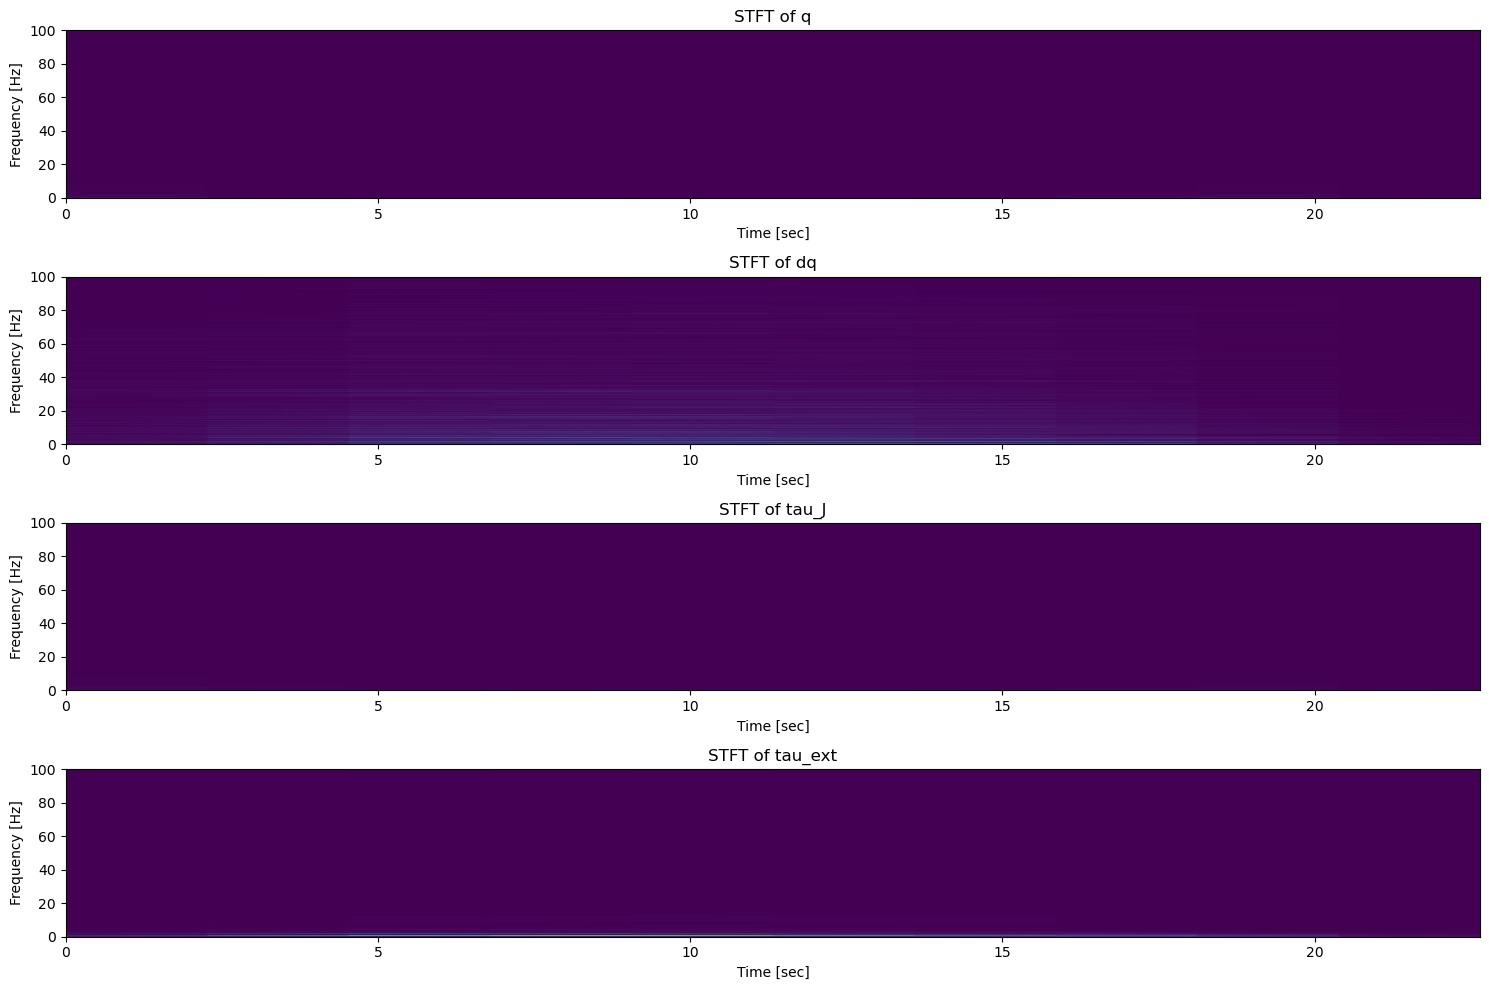

In [32]:
# 画出时频图
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.pcolormesh(t_q, f_q, np.abs(Zxx_q), shading='gouraud')
plt.title('STFT of q')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(4, 1, 2)
plt.pcolormesh(t_dq, f_dq, np.abs(Zxx_dq), shading='gouraud')
plt.title('STFT of dq')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(4, 1, 3)
plt.pcolormesh(t_tau_J, f_tau_J, np.abs(Zxx_tau_J), shading='gouraud')
plt.title('STFT of tau_J')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(4, 1, 4)
plt.pcolormesh(t_tau_ext, f_tau_ext, np.abs(Zxx_tau_ext), shading='gouraud')
plt.title('STFT of tau_ext')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.tight_layout()
plt.show()
